# Тестирование библиотеки пакетной генерации карточек

Этот ноутбук демонстрирует работу библиотеки `batch_card_generation_pipeline.py` для пакетной генерации и оценки карточек.

In [1]:
import sys
import os
from pathlib import Path

# Добавляем путь к модулю в PYTHONPATH
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)

from vocab_preparation.batch_card_generation_pipeline import (
    process_cards_batch,
    create_cards_list,
    TranslationQuality
)

## Подготовка тестовых данных

Создадим тестовый набор карточек для проверки работы библиотеки.

In [2]:
import openai
from openai import AzureOpenAI, AsyncAzureOpenAI
from tqdm.notebook import tqdm
import os
from dotenv import load_dotenv, find_dotenv
import requests
import base64

GPT_3_5_TURBO = "gpt-3.5-turbo"
GPT_4_TURBO_PREVIEW = "gpt-4-turbo-preview"
GPT_4 = 'gpt-4'
GPT_4o = 'gpt-4o'

def get_openai_api_key():
    _ = load_dotenv(find_dotenv())

    return os.getenv("OPENAI_API_KEY")

OPENAI_API_KEY = get_openai_api_key()
azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2024-07-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

In [3]:
source_lang = 'Finnish'
secondary_lang = 'Russian'
target_lang = 'English'

In [4]:
import json


EVAL_FOLDER = '../../data/russian-english/cards/eval_results/ru_eng_'
def get_ru_finn_eval_results_from_file(file_name):
    data = []
    file_path = EVAL_FOLDER + file_name
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

EVAL_FOLDER = '../../data/english-finnish/cards/eval_results/eng_finn_'
def get_eng_finn_eval_results_from_file(file_name):
    data = []
    file_path = EVAL_FOLDER + file_name
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

RU_ENG_OUTPUT_FOLDER = '../../data/russian-english/cards/test_cards/ru_eng_'
def get_ru_eng_cards_from_file(file_name):
    data = []
    file_path = OUTPUT_FOLDER + file_name
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data


RU_FINN_FOLDER_WITH_JSON = '../../data/russian-finnish/cards/curated_platform_cards/'
def get_ru_finn_cards_from_file(file_name):
    data = []
    file_path = RU_FINN_FOLDER_WITH_JSON + file_name
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    res = []
    for card in data:
        if 'isMarkedDeleted' not in card.keys():
            res.append(card)
    return res


ENG_FINN_OUTPUT_FOLDER = '../../data/english-finnish/cards/test_cards/eng_finn_'
def get_eng_finn_cards_from_file(file_name):
    data = []
    file_path = ENG_FINN_OUTPUT_FOLDER + file_name
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data


OUTPUT_FOLDER = '../../data/english-finnish/cards/test_cards/eng_finn_'
def write_cards_to_file(file_name, cards):
    file_path = OUTPUT_FOLDER + file_name
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(cards, f, ensure_ascii=False, indent=2)
        
        
EVAL_FOLDER = '../../data/english-finnish/cards/eval_results/eng_finn_'
def write_eval_results_to_file(file_name, results):
    file_path = EVAL_FOLDER + file_name
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)

In [5]:
def get_ru_fi_cards():
    all_cards = list()
    
    file_names = [f'sm1_new_kap{i}.json' for i in range(1, 10)]
    file_names.extend([f'sm2_new_kap{i}.json' for i in range(1, 9)])
    file_names.append('sm2_new_puhekieli.json')
    file_names.extend([f'sm3_kap{i}.json' for i in range(1, 9)])
    file_names.extend([f'sm4_kap{i}.json' for i in range(1, 6)])
    
    for file_name in file_names:
        cards = get_ru_finn_cards_from_file(file_name)
        all_cards.extend(cards)
    
    return all_cards

In [6]:
import numpy as np

ru_fi_cards_sample = np.random.choice(list(get_ru_fi_cards()), size=300, replace=False)

## Создание списков карточек

Разделим карточки на исходный и вторичный языки.

In [8]:
secondary_cards = [{'word': card["wordFirstLang"], 'sentence': card["sentenceFirstLang"], 'id': card["id"]} for card in ru_fi_cards_sample]
source_cards = [{'word': card["wordSecondLang"], 'sentence': card["sentenceSecondLang"], 'id': card["id"]} for card in ru_fi_cards_sample]

print(f"Количество карточек: {len(source_cards)}")
print("\nПример карточки на исходном языке:")
print(source_cards[0])
print("\nПример карточки на вторичном языке:")
print(secondary_cards[0])

Количество карточек: 300

Пример карточки на исходном языке:
{'word': 'häneen', 'sentence': 'Koskit häneen.', 'id': 2905}

Пример карточки на вторичном языке:
{'word': 'к нему, к ней', 'sentence': 'Ты прикоснулся к нему.', 'id': 2905}


## Тестирование пакетной генерации

Запустим процесс генерации карточек с разными размерами пакетов для сравнения производительности.

In [13]:
import time
from tqdm.notebook import tqdm

def test_batch_size(batch_size: int):
    start_time = time.time()
    
    generated_cards, evaluation_results = process_cards_batch(
        source_cards,
        secondary_cards,
        source_lang="Finnish",
        target_lang="English",
        secondary_lang="Russian",
        batch_size=batch_size,
        max_improvement_attempts=5,  # Changed from max_iterations
        max_retries=10
    )
    
    end_time = time.time()
    duration = end_time - start_time
    
    # Calculate statistics
    total_cards = len(source_cards)
    successful_cards = len(generated_cards)
    failed_cards = total_cards - successful_cards
    
    return {
        "batch_size": batch_size,
        "duration": duration,
        "cards_per_second": successful_cards / duration if duration > 0 else 0,
        "success_rate": successful_cards / total_cards if total_cards > 0 else 0,
        "total_cards": total_cards,
        "successful_cards": successful_cards,
        "failed_cards": failed_cards,
        "generated_cards": generated_cards,
        "evaluation_results": evaluation_results
    }

def print_results(results):
    print("\nРезультаты тестирования различных размеров батча:")
    print("-" * 80)
    print(f"{'Размер батча':<15} {'Время (с)':<15} {'Карточек/с':<15} {'Успешность':<15} {'Успешных':<15} {'Неудачных':<15}")
    print("-" * 80)
    
    for result in results:
        print(f"{result['batch_size']:<15} "
              f"{result['duration']:.2f} сек{'':<8} "
              f"{result['cards_per_second']:.2f}{'':<8} "
              f"{result['success_rate']*100:.1f}%{'':<8} "
              f"{result['successful_cards']:<15} "
              f"{result['failed_cards']:<15}")

# Тестируем разные размеры батча
batch_sizes = [1, 2, 3, 5]
results = []

for batch_size in tqdm(batch_sizes, desc="Тестирование размеров батча"):
    result = test_batch_size(batch_size)
    results.append(result)

# Выводим результаты
print_results(results)

Тестирование размеров батча:   0%|          | 0/4 [00:00<?, ?it/s]


Результаты тестирования различных размеров батча:
--------------------------------------------------------------------------------
Размер батча    Время (с)       Карточек/с      Успешность      Успешных        Неудачных      
--------------------------------------------------------------------------------
1               6168.21 сек         0.05         96.0%         288             12             
2               3317.83 сек         0.09         97.0%         291             9              
3               2579.85 сек         0.11         97.7%         293             7              
5               1466.09 сек         0.20         98.3%         295             5              


## Анализ результатов

Проанализируем результаты тестирования разных размеров пакетов.

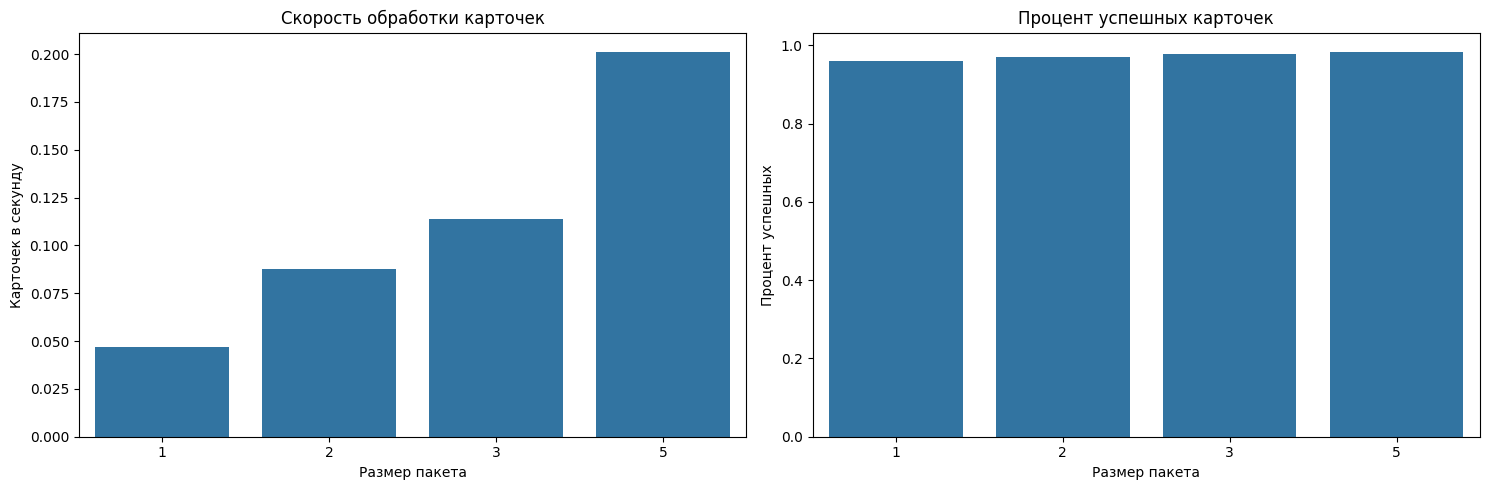

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


results_df = pd.DataFrame([{
    'batch_size': r['batch_size'],
    'duration': r['duration'],
    'cards_per_second': r['cards_per_second'],
    'success_rate': r['success_rate']
} for r in results])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=results_df, x='batch_size', y='cards_per_second', ax=ax1)
ax1.set_title('Скорость обработки карточек')
ax1.set_xlabel('Размер пакета')
ax1.set_ylabel('Карточек в секунду')

sns.barplot(data=results_df, x='batch_size', y='success_rate', ax=ax2)
ax2.set_title('Процент успешных карточек')
ax2.set_xlabel('Размер пакета')
ax2.set_ylabel('Процент успешных')

plt.tight_layout()
plt.show()

## Анализ качества переводов

Проанализируем качество переводов для лучшего размера пакета.

In [15]:
# Находим лучший результат по скорости
best_result = max(results, key=lambda x: x['cards_per_second'])

print(f"Лучший размер пакета: {best_result['batch_size']}")
print(f"Скорость обработки: {best_result['cards_per_second']:.2f} карточек/сек")
print(f"Процент успешных: {best_result['success_rate']*100:.1f}%")

# Анализируем результаты оценки
evaluation_metrics = {
    'sentenceCorrectness': 0,
    'wordUsage': 0,
    'wordTranslationAccuracy': 0,
    'sentenceTranslationAccuracy': 0
}

for eval_result in best_result['evaluation_results']:
    for metric in evaluation_metrics:
        if eval_result[metric]['isCorrect']:
            evaluation_metrics[metric] += 1

print("\nСтатистика по критериям оценки:")
for metric, count in evaluation_metrics.items():
    percentage = (count / len(best_result['evaluation_results'])) * 100
    print(f"{metric}: {percentage:.1f}%")

print("\nПримеры переводов:")
for i, (source, generated) in enumerate(zip(source_cards[:3], best_result['generated_cards'][:3])):
    print(f"\nКарточка {i+1}:")
    print(f"Исходное слово (FI): {source['word']}")
    print(f"Переведенное слово (EN): {generated['word']}")
    print(f"Исходное предложение (FI): {source['sentence']}")
    print(f"Переведенное предложение (EN): {generated['sentence']}")

Лучший размер пакета: 5
Скорость обработки: 0.20 карточек/сек
Процент успешных: 98.3%

Статистика по критериям оценки:
sentenceCorrectness: 100.0%
wordUsage: 100.0%
wordTranslationAccuracy: 100.0%
sentenceTranslationAccuracy: 100.0%

Примеры переводов:

Карточка 1:
Исходное слово (FI): maailmanmestaruuskilpailut
Переведенное слово (EN): world championship
Исходное предложение (FI): Maailmanmestaruuskilpailut järjestetään ensi kuussa.
Переведенное предложение (EN): The World Championship will take place next month.

Карточка 2:
Исходное слово (FI): nauraa
Переведенное слово (EN): laugh
Исходное предложение (FI): Lapsi nauraa.
Переведенное предложение (EN): The child is laughing.

Карточка 3:
Исходное слово (FI): piirre
Переведенное слово (EN): trait
Исходное предложение (FI): Hänen paras piirteensä on ystävällisyys.
Переведенное предложение (EN): His/her best trait is kindness.


### Тестирование генерации с помощью MoA

In [ ]:
import time
from tqdm.notebook import tqdm

def test_batch_size(batch_size: int):
    start_time = time.time()
    
    generated_cards, evaluation_results = process_cards_batch(
        source_cards,
        secondary_cards,
        source_lang="Finnish",
        target_lang="English",
        secondary_lang="Russian",
        batch_size=batch_size,
        max_improvement_attempts=5,  # Changed from max_iterations
        max_retries=10,
        use_moa=True
    )
    
    end_time = time.time()
    duration = end_time - start_time
    
    # Calculate statistics
    total_cards = len(source_cards)
    successful_cards = len(generated_cards)
    failed_cards = total_cards - successful_cards
    
    return {
        "batch_size": batch_size,
        "duration": duration,
        "cards_per_second": successful_cards / duration if duration > 0 else 0,
        "success_rate": successful_cards / total_cards if total_cards > 0 else 0,
        "total_cards": total_cards,
        "successful_cards": successful_cards,
        "failed_cards": failed_cards,
        "generated_cards": generated_cards,
        "evaluation_results": evaluation_results
    }

def print_results(results):
    print("\nРезультаты тестирования различных размеров батча:")
    print("-" * 80)
    print(f"{'Размер батча':<15} {'Время (с)':<15} {'Карточек/с':<15} {'Успешность':<15} {'Успешных':<15} {'Неудачных':<15}")
    print("-" * 80)
    
    for result in results:
        print(f"{result['batch_size']:<15} "
              f"{result['duration']:.2f} сек{'':<8} "
              f"{result['cards_per_second']:.2f}{'':<8} "
              f"{result['success_rate']*100:.1f}%{'':<8} "
              f"{result['successful_cards']:<15} "
              f"{result['failed_cards']:<15}")

# Тестируем разные размеры батча
batch_sizes = [1, 2, 3, 5]
moa_results = []

for batch_size in tqdm(batch_sizes, desc="Тестирование размеров батча"):
    result = test_batch_size(batch_size)
    moa_results.append(result)

# Выводим результаты
print_results(moa_results)

Тестирование размеров батча:   0%|          | 0/4 [00:00<?, ?it/s]

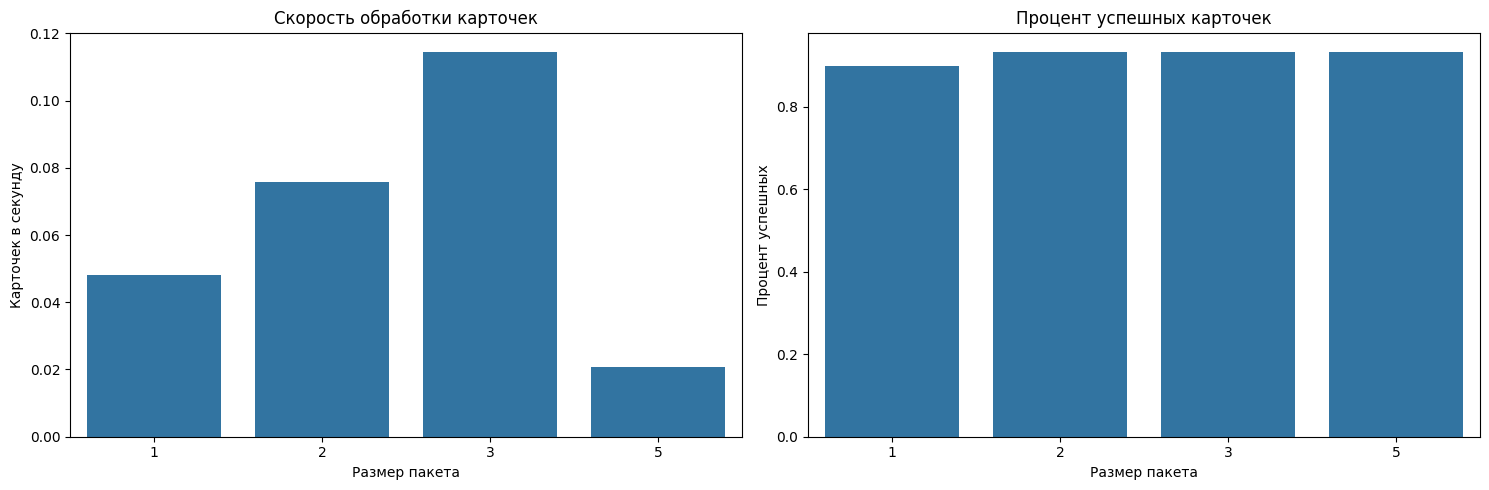

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


moa_results_df = pd.DataFrame([{
    'batch_size': r['batch_size'],
    'duration': r['duration'],
    'cards_per_second': r['cards_per_second'],
    'success_rate': r['success_rate']
} for r in moa_results])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=moa_results_df, x='batch_size', y='cards_per_second', ax=ax1)
ax1.set_title('Скорость обработки карточек')
ax1.set_xlabel('Размер пакета')
ax1.set_ylabel('Карточек в секунду')

sns.barplot(data=moa_results_df, x='batch_size', y='success_rate', ax=ax2)
ax2.set_title('Процент успешных карточек')
ax2.set_xlabel('Размер пакета')
ax2.set_ylabel('Процент успешных')

plt.tight_layout()
plt.show()